In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cst
from scipy.signal import butter,filtfilt
from scipy.optimize import fsolve
from scipy.integrate import odeint
from scipy import linalg

In [2]:
# Natural Constances
q = 1.60217663e-19 # Elementary Charge
hbar = 1.054571817e-34 # Reduced Plank const
kB = 1.380649e-23 # Boltzmann const

In [2]:
# Class Declaration (From https://github.com/arpitranadive/JJ_metamaterial_simulation/blob/master/dispersion_and_gain_in_TWPAs.py)

class dispersion_in_JJ_metamaterial:

	def __init__(self):

		self.version = '0.1.1'

		self.pump_frequency = None				# in GHz
		self.incident_pump_amplitude = None		
		self.phi_ext = np.pi 					# external magnetic flux in the loop		

		self.loss_tangent = None				# loss tangent
		self.number_of_loops = None				# number of loops in the transmission line
		self.size_of_one_loop = None			# size of one SNAIL loop in m
		self.I0 = None							# critical current of large junction
		self.I0_ratio = None					# ratio of critical currents in the SNAIL
		self.C_g = None							# ground capacitance
		self.C_J = None							# junction capacitance

		self.gamma = None						# kerr nonlinearity
		self.L_loop = None						# loop inductance
		self.noise = None

		self.phi_0 = 2e-15



	def linear_to_dB(self,linear):

		return 10*(np.log10(linear))


	def I(self,phi_s):

		return self.I0_ratio*self.I0*np.sin(phi_s)+self.I0*np.sin((phi_s-self.phi_ext)/3.0)


	def calculate_loop_parameters(self):

		phi_smin = fsolve(self.I, 0)
		gamma_tilde = (1.0/6)*(self.I0_ratio*np.cos(phi_smin)+(1.0/27)*np.cos((phi_smin-self.phi_ext)/3.0))
		alpha_tilde = self.I0_ratio*np.cos(phi_smin)+(1.0/3)*np.cos((phi_smin-self.phi_ext)/3.0)
		self.gamma = gamma_tilde/alpha_tilde
		self.L_loop = abs(1.0*self.phi_0/(alpha_tilde*self.I0*2*np.pi))


	def phase_mismatch(self,w_s):

		pump_frequency = self.pump_frequency
		pump_amplitude = self.incident_pump_amplitude
		loss_tangent = self.loss_tangent
		gamma = self.gamma
		L_loop = self.L_loop
		C_g = self.C_g
		C_J = self.C_J

		w_p = pump_frequency*1e9*2*np.pi
		w_i = 2*w_p-w_s
		w_0 = 1.0/(np.sqrt(L_loop*C_g))
		w_J = 1.0/(np.sqrt(L_loop*C_J))
		k_p = w_p/(w_0*np.sqrt(1-(w_p/w_J)**2))
		k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
		k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))
		w_til_p = 1-(w_p/w_J)**2
		w_til_s = 1-(w_s/w_J)**2
		w_til_i = 1-(w_i/w_J)**2
		k_p_loss = loss_tangent*k_p/2
		pump_amplitude_reduced = pump_amplitude*np.exp(-k_p_loss*self.number_of_loops/2)
		eta_p = 3*gamma*(k_p**3)*(pump_amplitude_reduced**2)/(8*w_til_p)
		eta_s = 3*gamma*2*(k_p**2)*k_s*(pump_amplitude_reduced**2)/(8*w_til_s)
		eta_i = 3*gamma*2*(k_p**2)*k_i*(pump_amplitude_reduced**2)/(8*w_til_i)
		del_k_disp = 2*k_p-k_i-k_s
		del_kerr = 2*eta_p-eta_i-eta_s
		del_k_total = del_k_disp + del_kerr
		return del_k_disp, del_kerr, del_k_total


	def phase_mismatch_vs_frequency(self,freq_array):
		
		del_k_disp_array = np.array([])
		del_k_kerr_array = np.array([])
		del_k_total_array = np.array([])

		for freq in freq_array:

			del_k_disp, del_kerr, del_k_total = self.phase_mismatch(freq*1e9*2*np.pi)
			del_k_disp_array = np.append(del_k_disp_array,del_k_disp)
			del_k_kerr_array = np.append(del_k_kerr_array,del_kerr)
			del_k_total_array = np.append(del_k_total_array,del_k_total)

		return del_k_disp_array/self.size_of_one_loop, del_k_kerr_array/self.size_of_one_loop, del_k_total_array/self.size_of_one_loop


	def gain(self,w_s):

		pump_frequency = self.pump_frequency
		pump_amplitude = self.incident_pump_amplitude
		loss_tangent = self.loss_tangent
		gamma = self.gamma
		L_loop = self.L_loop
		C_g = self.C_g
		C_J = self.C_J
		number_of_loops = self.number_of_loops

		w_p = pump_frequency*1e9*2*np.pi
		w_i = 2*w_p-w_s
		w_0 = 1.0/(np.sqrt(L_loop*C_g))
		w_J = 1.0/(np.sqrt(L_loop*C_J))
		k_p = w_p/(w_0*np.sqrt(1-(w_p/w_J)**2))
		k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
		k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))
		w_til_p = 1-(w_p/w_J)**2
		w_til_s = 1-(w_s/w_J)**2
		w_til_i = 1-(w_i/w_J)**2
		k_p_loss = loss_tangent*k_p/2
		pump_amplitude_reduced = pump_amplitude*np.exp(-k_p_loss*number_of_loops/2)
		eta_p = 3*gamma*(k_p**3)*(pump_amplitude_reduced**2)/(8*w_til_p)
		eta_s = 3*gamma*2*(k_p**2)*k_s*(pump_amplitude_reduced**2)/(8*w_til_s)
		eta_i = 3*gamma*2*(k_p**2)*k_i*(pump_amplitude_reduced**2)/(8*w_til_i)
		del_k_disp = 2*k_p-k_i-k_s
		del_kerr = 2*eta_p-eta_i-eta_s
		del_k_total = del_k_disp + del_kerr

		k_i_loss = loss_tangent*k_i/2
		k_s_loss = loss_tangent*k_s/2
		Phi11 = -1j*0.5*del_k_total-k_s_loss
		Phi12 = 1j*eta_s*k_i/(k_s*2)
		Phi21 = -1j*eta_i*k_s/(k_i*2)
		Phi22 = 1j*0.5*del_k_total-k_i_loss
		# print(Phi11)
		matrix_Phi = np.array([[Phi11[0],Phi12[0]],[Phi21[0],Phi22[0]]])

		exp_Phi = linalg.expm(matrix_Phi*number_of_loops)

		if self.noise:
			exp_Phi[0][0] += np.sqrt(complex(k_s_loss))/2/np.pi
			exp_Phi[1][1] += np.sqrt(complex(k_i_loss))/2/np.pi
		
		gain_lin = abs(exp_Phi[0][0])**2

		return self.linear_to_dB(gain_lin)


	def gain_vs_freq(self,freq_array):
		
		gain_array = np.array([])

		for freq_s in freq_array:

			w_s = freq_s*1e9*2*np.pi
			gain_array = np.append(gain_array,self.gain(w_s))

		return gain_array

	# Custom Plotting Functions

	def gain_vs_ground_cap(self, cap_array, w_s):
		
		gain_array = np.array([])
		w_s = w_s*1e9*2*np.pi

		for Cg in cap_array:
			self.I0_ratio = Cg
			self.calculate_loop_parameters()
			gain_array = np.append(gain_array,self.gain(w_s))

		return gain_array

	def plot_g4_vs_flux(self, flux_range):
		g4s = []
		for flux_ratio in flux_range:
			self.phi_ext = 2*np.pi*flux_ratio
			self.calculate_loop_parameters()
			g4s.append(self.gamma * q**2 / 4 / self.C_g / hbar * 1e-6) #MHz

		plt.figure(figsize=(8, 6))
		plt.plot(flux_range, g4s)
		plt.xlabel('Quantized Flux')
		plt.ylabel('g4 (MHz)')
		plt.grid(True)
		plt.show()

# Device Simulations Without Noise

#### Device Declaration

In [4]:
sim = dispersion_in_JJ_metamaterial()

sim.pump_frequency = 8				# in GHz
sim.incident_pump_amplitude = 1.6		

sim.loss_tangent = -1e-6 			# loss tangent
sim.number_of_loops = 700			# number of loops in the transmission line
sim.size_of_one_loop = 4e-6 	    # size of one SNAIL loop in m
sim.I0 = 2.19e-6					# critical current of large junction
sim.I0_ratio = 0.07					# ratio of critical currents in the SNAIL
sim.C_g = 250e-15					# ground capacitance
sim.C_J = 50e-15					# junction capacitance

def plot(func, x, lables=None, title=None):
    func_vals = []
    for val in x:
        # simulation.phi_ext = 2*np.pi*flux_ratio
        # simulation.calculate_loop_parameters()
        func_vals.append(func(val)) #MHz

    plt.figure(figsize=(8, 6))
    plt.plot(x, func_vals)
    plt.xlabel(lables[0])
    plt.ylabel(lables[1])
    plt.title(title)
    plt.grid(True)
    plt.show()

In [5]:
# cg_range = np.linspace(0, 1, 1000)
# gain_values = sim.gain_vs_ground_cap(cg_range, 8) # w in GHz

# plt.figure(figsize=(8, 6))
# plt.plot(cg_range, gain_values)
# plt.xlabel("Ground Capacitance (fF)")
# plt.ylabel("Gain (dB)")
# plt.grid(True)
# plt.show()

# Phase Mismatch vs. Frequency (Fig. 1b)

[-0.02086263] [5.51950557e-10]


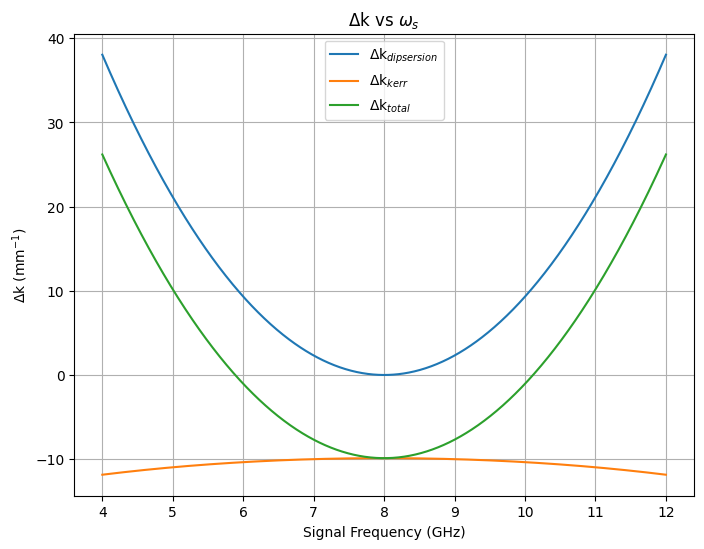

In [6]:
sim.phi_ext = np.pi					# external magnetic flux in the loop	
sim.calculate_loop_parameters()
print(sim.gamma, sim.L_loop)

omega_s_range = np.linspace(4, 12, 1000)
dk_disp_values = -sim.phase_mismatch_vs_frequency(omega_s_range)[0]*sim.size_of_one_loop/1e-3
dk_kerr_values = -sim.phase_mismatch_vs_frequency(omega_s_range)[1]*sim.size_of_one_loop/1e-3
dk_tot_values = -sim.phase_mismatch_vs_frequency(omega_s_range)[2]*sim.size_of_one_loop/1e-3


plt.figure(figsize=(8, 6))
plt.plot(omega_s_range, dk_disp_values, label=r'$\Delta$k$_{dipsersion}$')
plt.plot(omega_s_range, dk_kerr_values, label=r'$\Delta$k$_{kerr}$')
plt.plot(omega_s_range, dk_tot_values, label=r'$\Delta$k$_{total}$')
plt.xlabel('Signal Frequency (GHz)')
plt.ylabel(r'$\Delta$k (mm$^{-1}$)')
plt.title(r'$\Delta$k vs $\omega_s$')
plt.grid(True)
plt.legend()
plt.show()

# Gain vs. Signal Frequency at fixed Pump Frequency (Fig. 1c)

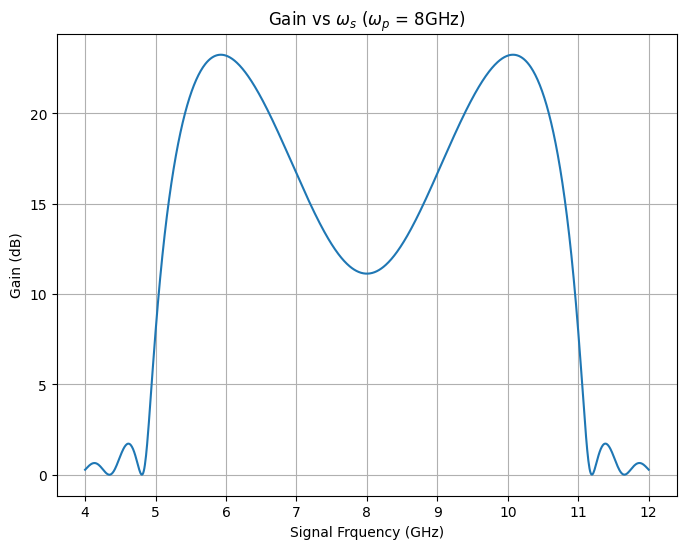

In [7]:
omega_s_range = np.linspace(4, 12, 1000)
gain_values = sim.gain_vs_freq(omega_s_range)

plt.figure(figsize=(8, 6))
plt.plot(omega_s_range, gain_values)
plt.xlabel('Signal Frquency (GHz)')
plt.ylabel(r'Gain (dB)')
plt.title(r'Gain vs $\omega_s$ ($\omega_p$ = 8GHz)')
plt.grid(True)
plt.show()

# Gain Parameter ($g_4$) vs. Flux (Fig. 2a)

Nonlinear coefficient g4 as a function of the external magnetic flux, calculated using the device parameters obtained from the linear characterization 

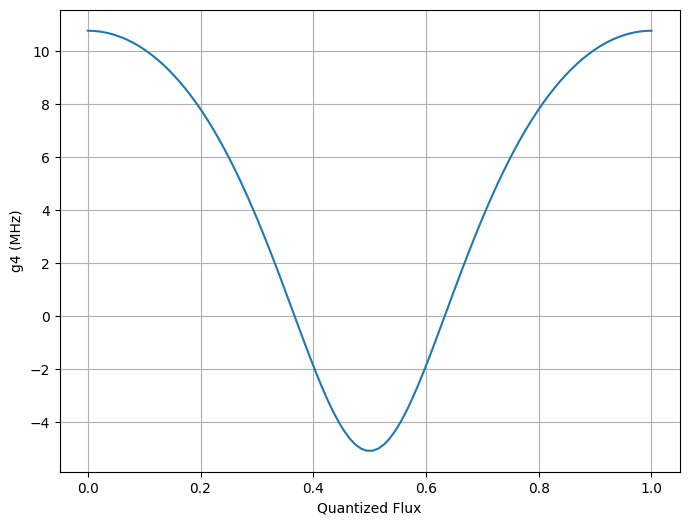

In [8]:
flux_range = np.linspace(0,1,100)
sim.plot_g4_vs_flux(flux_range)

# Gain vs. Signal Frequency for several Pump Frequencies

Pump Amplitude is an experiemental variable, determined by the required power for a signal at an operating signal frequency.

These plots are fit to the data.

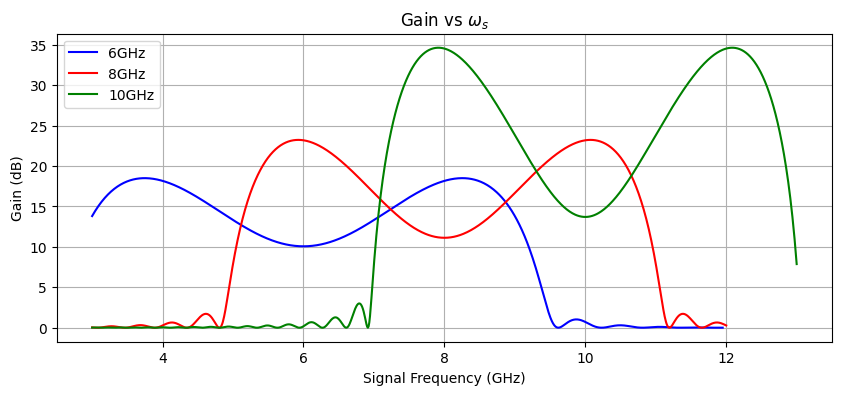

In [116]:
sim.phi_ext = np.pi					# external magnetic flux in the loop	
sim.calculate_loop_parameters()

omega_s_range_6GHZ = np.linspace(3, 11.95, 1000)
omega_s_range_8GHZ = np.linspace(3, 12, 1000)
omega_s_range_10GHZ = np.linspace(3, 13, 1000)

sim.pump_frequency = 6
sim.incident_pump_amplitude = 2.4
gain_values_6GHz = sim.gain_vs_freq(omega_s_range_6GHZ)

sim.pump_frequency = 8
sim.incident_pump_amplitude = 1.6
gain_values_8GHz = sim.gain_vs_freq(omega_s_range_8GHZ)

sim.pump_frequency = 10
sim.incident_pump_amplitude = 1.27
gain_values_10GHz = sim.gain_vs_freq(omega_s_range_10GHZ)

plt.figure(figsize=(10, 4))
plt.plot(omega_s_range_6GHZ, gain_values_6GHz, label=r'6GHz', color='b')
plt.plot(omega_s_range_8GHZ, gain_values_8GHz, label=r'8GHz', color='r')
plt.plot(omega_s_range_10GHZ, gain_values_10GHz, label=r'10GHz', color='g')
plt.xlabel('Signal Frequency (GHz)')
plt.ylabel(r'Gain (dB)')
plt.title(r'Gain vs $\omega_s$')
plt.grid(True)
plt.legend()
plt.show()

[2.26116141]
[1.45660146]
[1.16095908]


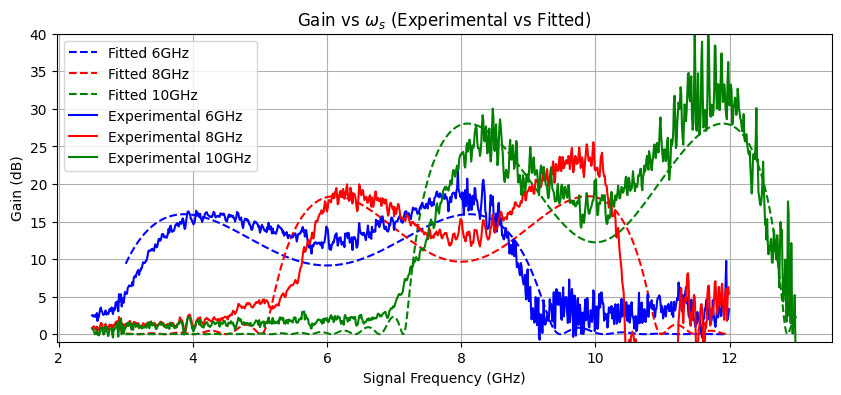

In [10]:
from scipy.optimize import curve_fit

sim.phi_ext = np.pi					# external magnetic flux in the loop	
sim.calculate_loop_parameters()

# Load experimental data
gain_data_6GHz = np.load('Data/gain_6.npy')
gain_freq_6GHz = np.load('Data/gain_6_freq.npy')

gain_data_8GHz = np.load('Data/gain_8.npy')
gain_freq_8GHz = np.load('Data/gain_8_freq.npy')

gain_data_10GHz = np.load('Data/gain_10.npy')
gain_freq_10GHz = np.load('Data/gain_10_freq.npy')

# Define fitting function with fixed frequency
def fit_function(omega_s_range, incident_pump_amplitude, fixed_pump_frequency):
    sim.pump_frequency = fixed_pump_frequency
    sim.incident_pump_amplitude = incident_pump_amplitude
    return sim.gain_vs_freq(omega_s_range)

# Perform curve fitting for each set of experimental data, fixing the frequency
fixed_pump_frequency_6GHz = 6
params_6GHz, _ = curve_fit(lambda omega_s_range, incident_pump_amplitude: fit_function(omega_s_range, incident_pump_amplitude, fixed_pump_frequency_6GHz),
                           gain_freq_6GHz, gain_data_6GHz, p0=[2.4], bounds=([0], [np.inf]), method='trf', loss='soft_l1', f_scale=0.1)

fixed_pump_frequency_8GHz = 8
params_8GHz, _ = curve_fit(lambda omega_s_range, incident_pump_amplitude: fit_function(omega_s_range, incident_pump_amplitude, fixed_pump_frequency_8GHz),
                           gain_freq_8GHz, gain_data_8GHz, p0=[1.6], bounds=([0], [np.inf]), method='trf', loss='soft_l1', f_scale=0.1)

fixed_pump_frequency_10GHz = 10
params_10GHz, _ = curve_fit(lambda omega_s_range, incident_pump_amplitude: fit_function(omega_s_range, incident_pump_amplitude, fixed_pump_frequency_10GHz),
                            gain_freq_10GHz, gain_data_10GHz, p0=[1.27], bounds=([0], [np.inf]), method='trf', loss='soft_l1', f_scale=0.1)

# Generate fitted gain values using the optimal parameters
fitted_gain_6GHz = fit_function(omega_s_range_6GHZ, *params_6GHz, fixed_pump_frequency_6GHz)
fitted_gain_8GHz = fit_function(omega_s_range_8GHZ, *params_8GHz, fixed_pump_frequency_8GHz)
fitted_gain_10GHz = fit_function(omega_s_range_10GHZ, *params_10GHz, fixed_pump_frequency_10GHz)

print(params_6GHz)
print(params_8GHz)
print(params_10GHz)

# Plot the results
plt.figure(figsize=(10, 4))
plt.plot(omega_s_range_6GHZ, fitted_gain_6GHz, label=r'Fitted 6GHz', color = 'b', linestyle='--')
plt.plot(omega_s_range_8GHZ, fitted_gain_8GHz, label=r'Fitted 8GHz', color = 'r', linestyle='--')
plt.plot(omega_s_range_10GHZ, fitted_gain_10GHz, label=r'Fitted 10GHz', color = 'g', linestyle='--')
plt.plot(gain_freq_6GHz, gain_data_6GHz, label=r'Experimental 6GHz', color = 'b')
plt.plot(gain_freq_8GHz, gain_data_8GHz, label=r'Experimental 8GHz', color = 'r')
plt.plot(gain_freq_10GHz, gain_data_10GHz, label=r'Experimental 10GHz', color = 'g')
plt.xlabel('Signal Frequency (GHz)')
plt.ylabel(r'Gain (dB)')
plt.title(r'Gain vs $\omega_s$ (Experimental vs Fitted)')
plt.grid(True)
plt.ylim(-1,40)
plt.legend()
plt.show()

# Theoretical Gain vs. Pump Frequency and Signal Frequency

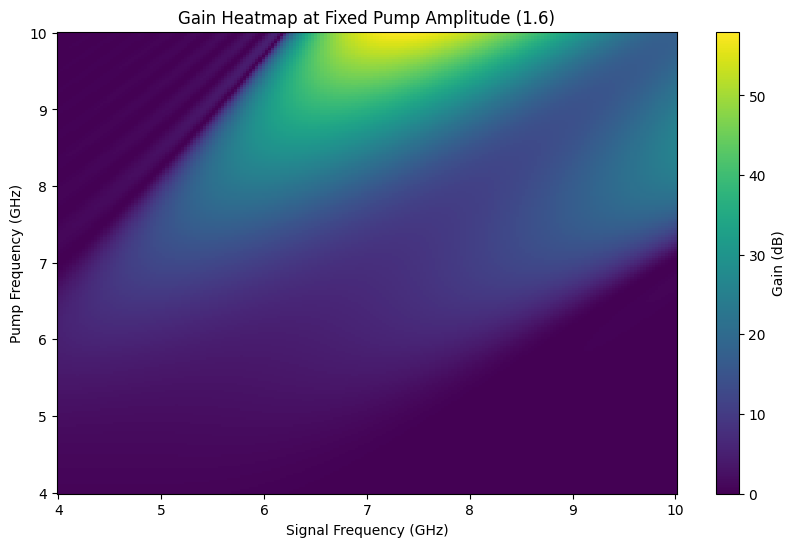

In [11]:
# Function to calculate gain values for a given pump frequency
def calculate_gain(pump_frequency, pump_amplitude, omega_s_range):
    sim.pump_frequency = pump_frequency
    sim.incident_pump_amplitude = pump_amplitude
    return sim.gain_vs_freq(omega_s_range)

# Pump frequencies and signal frequency range
pump_frequencies = np.linspace(4, 10, 200)
omega_s_range = np.linspace(4, 10, 200)

# Calculate gain values for each pump frequency
gain_matrix = np.array([calculate_gain(pump_freq, 1.6, omega_s_range) for pump_freq in pump_frequencies])

# Create a heatmap
plt.figure(figsize=(10, 6))
plt.pcolormesh(omega_s_range, pump_frequencies, gain_matrix, shading='auto', cmap='viridis')
plt.colorbar(label='Gain (dB)')
plt.xlabel('Signal Frequency (GHz)')
plt.ylabel('Pump Frequency (GHz)')
plt.title('Gain Heatmap at Fixed Pump Amplitude (1.6)')
plt.show()

# Theoretical Gain vs. Pump Amplitude and Signal Frequency

In [12]:
# Set noise to False
sim.noise = False

# Pump amplitudes and signal frequency range
pump_amplitudes = np.linspace(1, 15, 200)
omega_s_range = np.linspace(4, 10, 200)

# Calculate gain values for each pump amplitude
gain_matrix_no_noise = np.array([calculate_gain(6, pump_amp, omega_s_range) for pump_amp in pump_amplitudes])

# Set noise to True
# sim.noise = True

# Calculate gain values for each pump amplitude with noise
gain_matrix_with_noise = np.array([calculate_gain(6, pump_amp, omega_s_range) for pump_amp in pump_amplitudes])

# # Create subplots
# fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# # Plot with noise off
# pcm_no_noise = axs[0].pcolormesh(omega_s_range, pump_amplitudes, gain_matrix_no_noise, shading='auto', cmap='viridis')
# axs[0].set_title('Gain Heatmap (Noise Off)')
# axs[0].set_xlabel('Signal Frequency (GHz)')
# axs[0].set_ylabel('Pump Amplitude')
# axs[0].grid(True)
# axs[0].colorbar = plt.colorbar(pcm_no_noise, ax=axs[0], label='Gain (dB)')

# # Plot with noise on
# pcm_with_noise = axs[1].pcolormesh(omega_s_range, pump_amplitudes, gain_matrix_with_noise, shading='auto', cmap='viridis')
# axs[1].set_title('Gain Heatmap (Noise On)')
# axs[1].set_xlabel('Signal Frequency (GHz)')
# axs[1].set_ylabel('Pump Amplitude')
# axs[1].grid(True)
# axs[1].colorbar = plt.colorbar(pcm_with_noise, ax=axs[1], label='Gain (dB)')

# plt.tight_layout()
plt.show()

/var/folders/8g/g48bxxwn3139k68mrwrpq2xw0000gn/T/ipykernel_54237/10811950.py:137: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_Phi[0][0] += np.sqrt(complex(k_s_loss))/2/np.pi
/var/folders/8g/g48bxxwn3139k68mrwrpq2xw0000gn/T/ipykernel_54237/10811950.py:138: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_Phi[1][1] += np.sqrt(complex(k_i_loss))/2/np.pi


# Device Simulations With Noise

Utils

In [13]:
def plot_data(x, y, labels=None, legend_title=None, subplot_domain=None, xlim=None, ylim=None, ylog=None):
    
    xdata = [np.load(data) if type(data)==str else data for data in x]
    ydata = [np.load(data) if type(data)==str else data for data in y]

    if all([len(xdata[i]) != len(ydata[i]) for i in range(len(ydata))]):
        print('This data cannot be plotted, lengths do not match.')
    
    else:
        plt.figure(figsize=(8, 6))

        # Plot main data
        for data in zip(xdata, ydata, labels):
            if ylog:
                plt.semilogy(data[0], data[1], label=data[2])
            else:
                plt.plot(data[0], data[1], label=data[2])

        # Add legend
        if labels:
            plt.legend().set_title(legend_title) if legend_title else plt.legend()

        # Add subplot highlighting specified range
        if subplot_domain:
            ax = plt.subplot(111)
            indice_array = [np.where((xdata[i] >= subplot_domain[0]) & (xdata[i] <= subplot_domain[1]))[0] for i in range(len(xdata))]
            
            if len(indice_array) > 0:
                axins = ax.inset_axes([0.3, 0.2, 0.35, 0.35])  # Adjust position and size as needed
                for i in range(len(indice_array)):
                    axins.plot(xdata[i][indice_array[i]], ydata[i][indice_array[i]], color='red', label='Highlighted Range')
                ax.indicate_inset_zoom(axins, edgecolor="gray")
                axins.grid(True)
            else:
                print('No data within the specified range.')
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.grid(True)
        plt.show()

def save_to_csv(input_path, csv_output_path):
    loaded_data = np.load(input_path)
    np.savetxt(csv_output_path, loaded_data, delimiter=',')

# Gain Compression vs. Signal Power (Fig. 3d, Pumped at 8GHz)

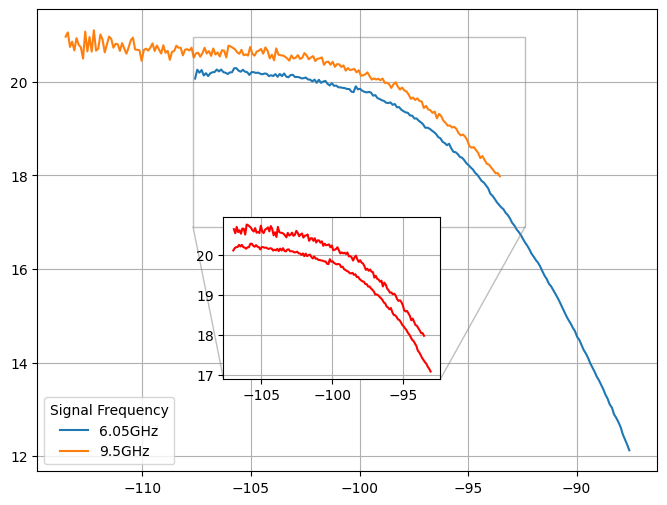

In [14]:
saturation_spectrum_60_path = 'Data/saturation_6_pow.npy'
saturation_spectrum_95_path = 'Data/saturation_9.5_pow.npy'

saturation_path_60 = 'Data/saturation_6_gain.npy'
saturation_path_95 = 'Data/saturation_9.5_gain.npy'

plot_data(x = [saturation_spectrum_60_path, saturation_spectrum_95_path], 
          y = [saturation_path_60, saturation_path_95], 
          labels=['6.05GHz','9.5GHz'],
          legend_title = 'Signal Frequency',
          subplot_domain = [-107,-93])

# Noise calibration
The noise calibration for the TWPA has been performed using a broadband thermal noise source with temperature tunability between 40 mK to 1 K. Using this noise source, we first calibrated the noise and gain performance of the output line (without TWPA). 

To calibrate the output line (excluding TWPA), we move the microwave switch to reference position and record the power spectral density (PSD) with a spectrum analyzer as a function of the temperature of noise source, over the desired frequency band. We fit the obtained PSD to standard noise model,

$$ P(\omega_s)=[N_{source}(\omega_s,T)+N_{out}(\omega_s)]G_{out}(\omega_s)B_w$$

For our data, the measurement bandwidth is $B_w = 200$ MHz. $G_{out}$ and $N_{out}$ are the fitting parameters, corresponding to the output line gain and noise.

$N_{source}$ is the thermal noise sorce noise given by the noise_source function:
$$N_{source}=\frac{\hbar \omega}{2}\coth(\hbar\omega/2k_BT)


The output noise power of the transmission line including TWPA, in the high TWPA gain limit can be expressed as,

$$ P(\omega)=[N_{source}(\omega_s,T_{source}) G_{TWPA}(\omega_s) + N_{TWPA}(\omega_s) G_{TWPA}(\omega_s)+ N_{source}(\omega_i,T_{source}) G_{TWPA}(\omega_i)+N_{out}(\omega_s)]G_{out}(\omega_s)B_w$$


In [28]:
PSD_freq = np.load('Data/noise_freq.npy')
thermal_noise = np.load('Data/noise_thermal_source_temperature.npy')
gain_without_TWPA = np.load('Data/noise_without_TWPA_sys_gain_dB.npy')
noise_without_TWPA = np.load('Data/noise_without_TWPA_temperature.npy')

In [107]:
from matplotlib import gridspec

noise_vs_freq_path = 'Data/noise_with_TWPA_PSD_vs_thermal_source_temperature.npy'

# Load data for the first figure
data_heatmap = np.load(noise_vs_freq_path)
temperature_values = thermal_noise
frequency_values = PSD_freq

#Declare temperature indices for plotting
temp_index_1, temp_index_2, temp_index_3 = 5, 350, 414

#Declare frequencies indices for plotting
signal_freq_index = 47

def coth(x):
    return 1 / np.tanh(x)

def noise_source(T, w):
    return hbar * w / 2 / kB * coth(hbar * w / 2 / kB / T)

In [139]:
sim = dispersion_in_JJ_metamaterial()

sim.pump_frequency = 8				# in GHz
sim.incident_pump_amplitude = 1.6

sim.loss_tangent = -1e-6 			# loss tangent
sim.number_of_loops = 700			# number of loops in the transmission line
sim.size_of_one_loop = 4e-6 	    # size of one SNAIL loop in m
sim.I0 = 2.19e-6					# critical current of large junction
sim.I0_ratio = 0.07					# ratio of critical currents in the SNAIL
sim.C_g = 250e-15					# ground capacitance
sim.C_J = 50e-15					# junction capacitance

sim.calculate_loop_parameters()

ws = PSD_freq[signal_freq_index] #GHz
wi = 2*sim.pump_frequency - ws

def PSD_with_TWPA(T, N_TWPA, Bw):
    return Bw * gain_without_TWPA[signal_freq_index] * (N_TWPA*sim.gain(ws*1e9*2*np.pi) + noise_without_TWPA[signal_freq_index] + noise_source(T, ws*1e9*2*np.pi)*sim.gain(ws*1e9*2*np.pi) + noise_source(T, wi*1e9*2*np.pi)*sim.gain(wi*1e9*2*np.pi)) # Nout in units of Kelvin, omega in units of GHz

# temps = np.linspace(0,0.4,100)
# plt.plot(temps, PSD_with_TWPA(temps, 0.2, 0.02))

/var/folders/8g/g48bxxwn3139k68mrwrpq2xw0000gn/T/ipykernel_54237/3848596354.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  heatmap = ax1.pcolormesh(frequency_values, temperature_values, data_heatmap, cmap='viridis')


N_TWPA:-18.90K 
B_w:2.079MHz


/var/folders/8g/g48bxxwn3139k68mrwrpq2xw0000gn/T/ipykernel_54237/3848596354.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


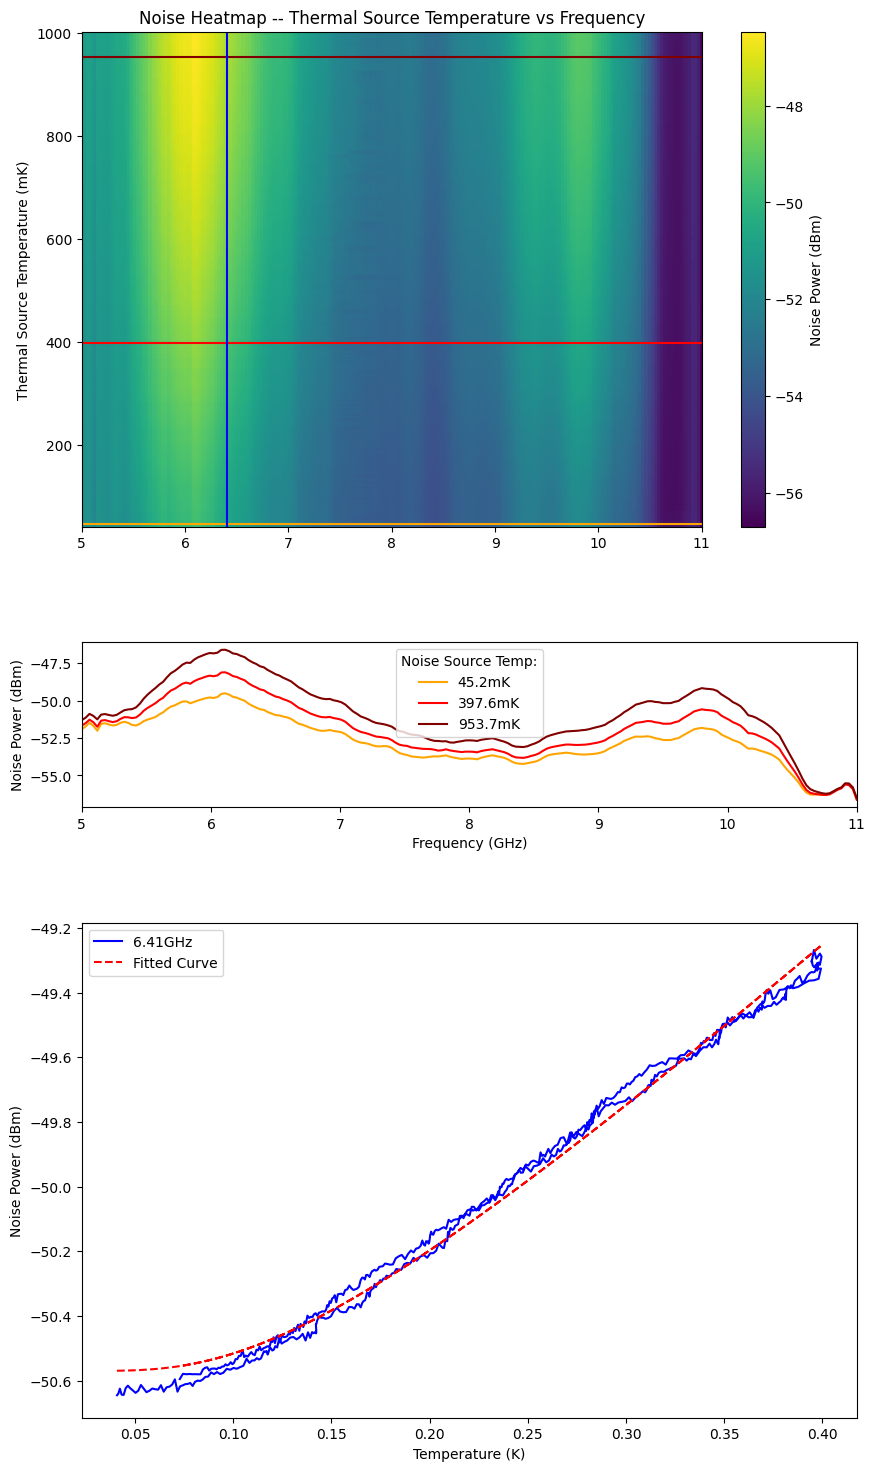

In [140]:
# Create a subplot grid with different heights for each subplot
fig = plt.figure(figsize=(10, 18))
gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 3], hspace=0.3)

# Plot the heatmap in the first subplot
ax1 = plt.subplot(gs[0])
heatmap = ax1.pcolormesh(frequency_values, temperature_values, data_heatmap, cmap='viridis')
ax1.set_ylabel('Thermal Source Temperature (mK)')
ax1.set_title('Noise Heatmap -- Thermal Source Temperature vs Frequency')
colorbar = fig.colorbar(heatmap, ax=ax1, label='Noise Power (dBm)')

# Plot horizontal lines corresponding to temperatures in the second subplot
ax1.axhline(temperature_values[temp_index_1], color='orange', linewidth=1.5)
ax1.axhline(temperature_values[temp_index_2], color='r', linewidth=1.5)
ax1.axhline(temperature_values[temp_index_3], color='maroon', linewidth=1.5)

# Plot vertical lines corresponding to frequencies in the third subplot
ax1.axvline(frequency_values[signal_freq_index], color='blue', linewidth=1.5)
# ax1.axvline(frequency_values[freq_index_2], color='navy', linestyle='--', linewidth=1.5)
# ax1.axvline(frequency_values[freq_index_3], color='purple', linestyle='--', linewidth=1.5)

# Plot the line plot in the second subplot
ax2 = plt.subplot(gs[1], sharex=ax1)
# ax2.set_title('Noise PSD')
ax2.plot(frequency_values, data_heatmap[temp_index_1], label=f'{temperature_values[temp_index_1]:.1f}mK', color='orange')
ax2.plot(frequency_values, data_heatmap[temp_index_2], label=f'{temperature_values[temp_index_2]:.1f}mK', color='r')
ax2.plot(frequency_values, data_heatmap[temp_index_3], label=f'{temperature_values[temp_index_3]:.1f}mK', color='maroon')
ax2.set_xlim([5, 11])
ax2.set_xlabel('Frequency (GHz)')
ax2.set_ylabel('Noise Power (dBm)')
ax2.legend(title='Noise Source Temp:')

end_fit = 800
# Filter the data where temperature is less than 0.4 K
filtered_indices = temperature_values / 1000 < 0.4
filtered_temperature_values = temperature_values[filtered_indices][0:end_fit] / 1000
filtered_data_heatmap = data_heatmap[filtered_indices][0:end_fit]

# Set up the initial guess for the fitting parameters Nout, Gout
initial_guess = [-20, 1e-3]

# Use curve_fit with bounds to fit the parameters
params, covariance = curve_fit(
    PSD_with_TWPA,
    filtered_temperature_values,
    filtered_data_heatmap.T[signal_freq_index],
    p0=initial_guess,
    maxfev = 10000
)

# Extract fitted parameters
N_TWPA_fit, Bw_fit = params

print(f'N_TWPA:{N_TWPA_fit:.2f}K \nB_w:{Bw_fit*1000:.3f}MHz')

# Generate the fitted curve
fitted_curve = PSD_with_TWPA(
    filtered_temperature_values, N_TWPA_fit, Bw_fit
)

# Plot the line plot in the third subplot
ax3 = plt.subplot(gs[2])
ax3.plot(
    filtered_temperature_values,
    filtered_data_heatmap.T[signal_freq_index],
    label=f"{frequency_values[signal_freq_index]:.2f}GHz",
    color="blue",
)
ax3.plot(
    filtered_temperature_values,
    fitted_curve,
    label="Fitted Curve",
    linestyle="--",
    color="red",
)
# ax3.set_xlim([0.05, 0.4])
# ax3.set_ylim([-50.75, -49.3])
ax3.set_xlabel("Temperature (K)")
ax3.set_ylabel("Noise Power (dBm)")
ax3.legend()

plt.tight_layout()

plt.show()

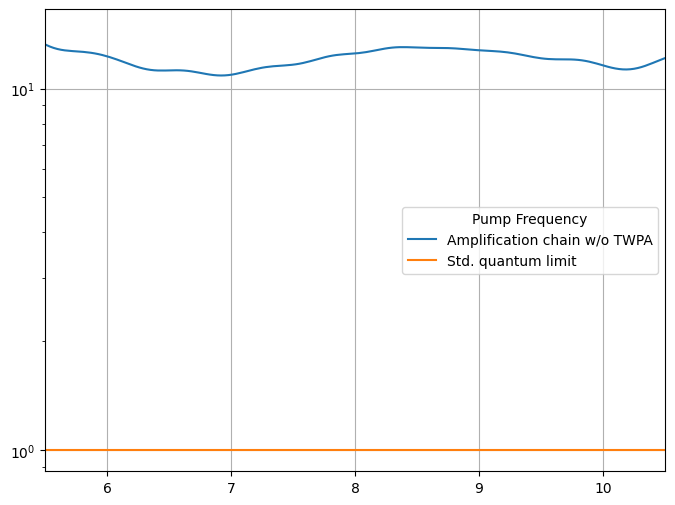

In [123]:

plot_data(x = [PSD_freq]*2, 
          y = [noise_without_TWPA*kB/hbar/PSD_freq/1e9/2/np.pi, [1]*len(PSD_freq)], 
          labels=['Amplification chain w/o TWPA', 'Std. quantum limit'],
          legend_title = 'Pump Frequency',
          xlim = (5.5,10.5),
          ylog=True)

# plot_data(x = [PSD_freq], 
#           y = [gain_without_TWPA],
#           labels=['8GHz'],
#           legend_title = 'Pump Frequency')


# Simulating Noiseless Device with Reduced Ground Capacitance

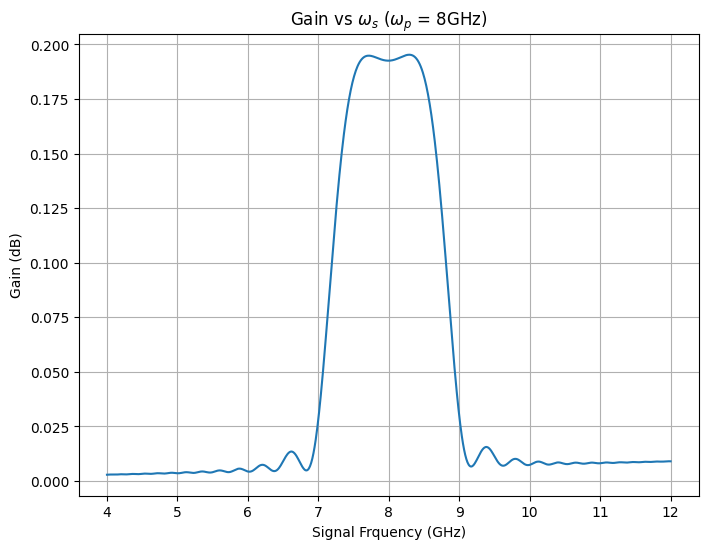

/var/folders/8g/g48bxxwn3139k68mrwrpq2xw0000gn/T/ipykernel_78458/10811950.py:112: RuntimeWarning: invalid value encountered in sqrt
  k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))
/var/folders/8g/g48bxxwn3139k68mrwrpq2xw0000gn/T/ipykernel_78458/10811950.py:129: RuntimeWarning: invalid value encountered in divide
  Phi21 = -1j*eta_i*k_s/(k_i*2)
/usr/local/lib/python3.11/site-packages/numpy/lib/scimath.py:135: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):
/usr/local/lib/python3.11/site-packages/scipy/linalg/_matfuncs.py:317: RuntimeWarning: invalid value encountered in divide
  sinchMu[mask] = np.sinh(mu[mask]) / mu[mask]
/var/folders/8g/g48bxxwn3139k68mrwrpq2xw0000gn/T/ipykernel_78458/10811950.py:111: RuntimeWarning: invalid value encountered in sqrt
  k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
/var/folders/8g/g48bxxwn3139k68mrwrpq2xw0000gn/T/ipykernel_78458/10811950.py:128: RuntimeWarning: invalid value encountered in divide
  Phi12 = 1j*eta_s*k_i/(k_s*2)
/var

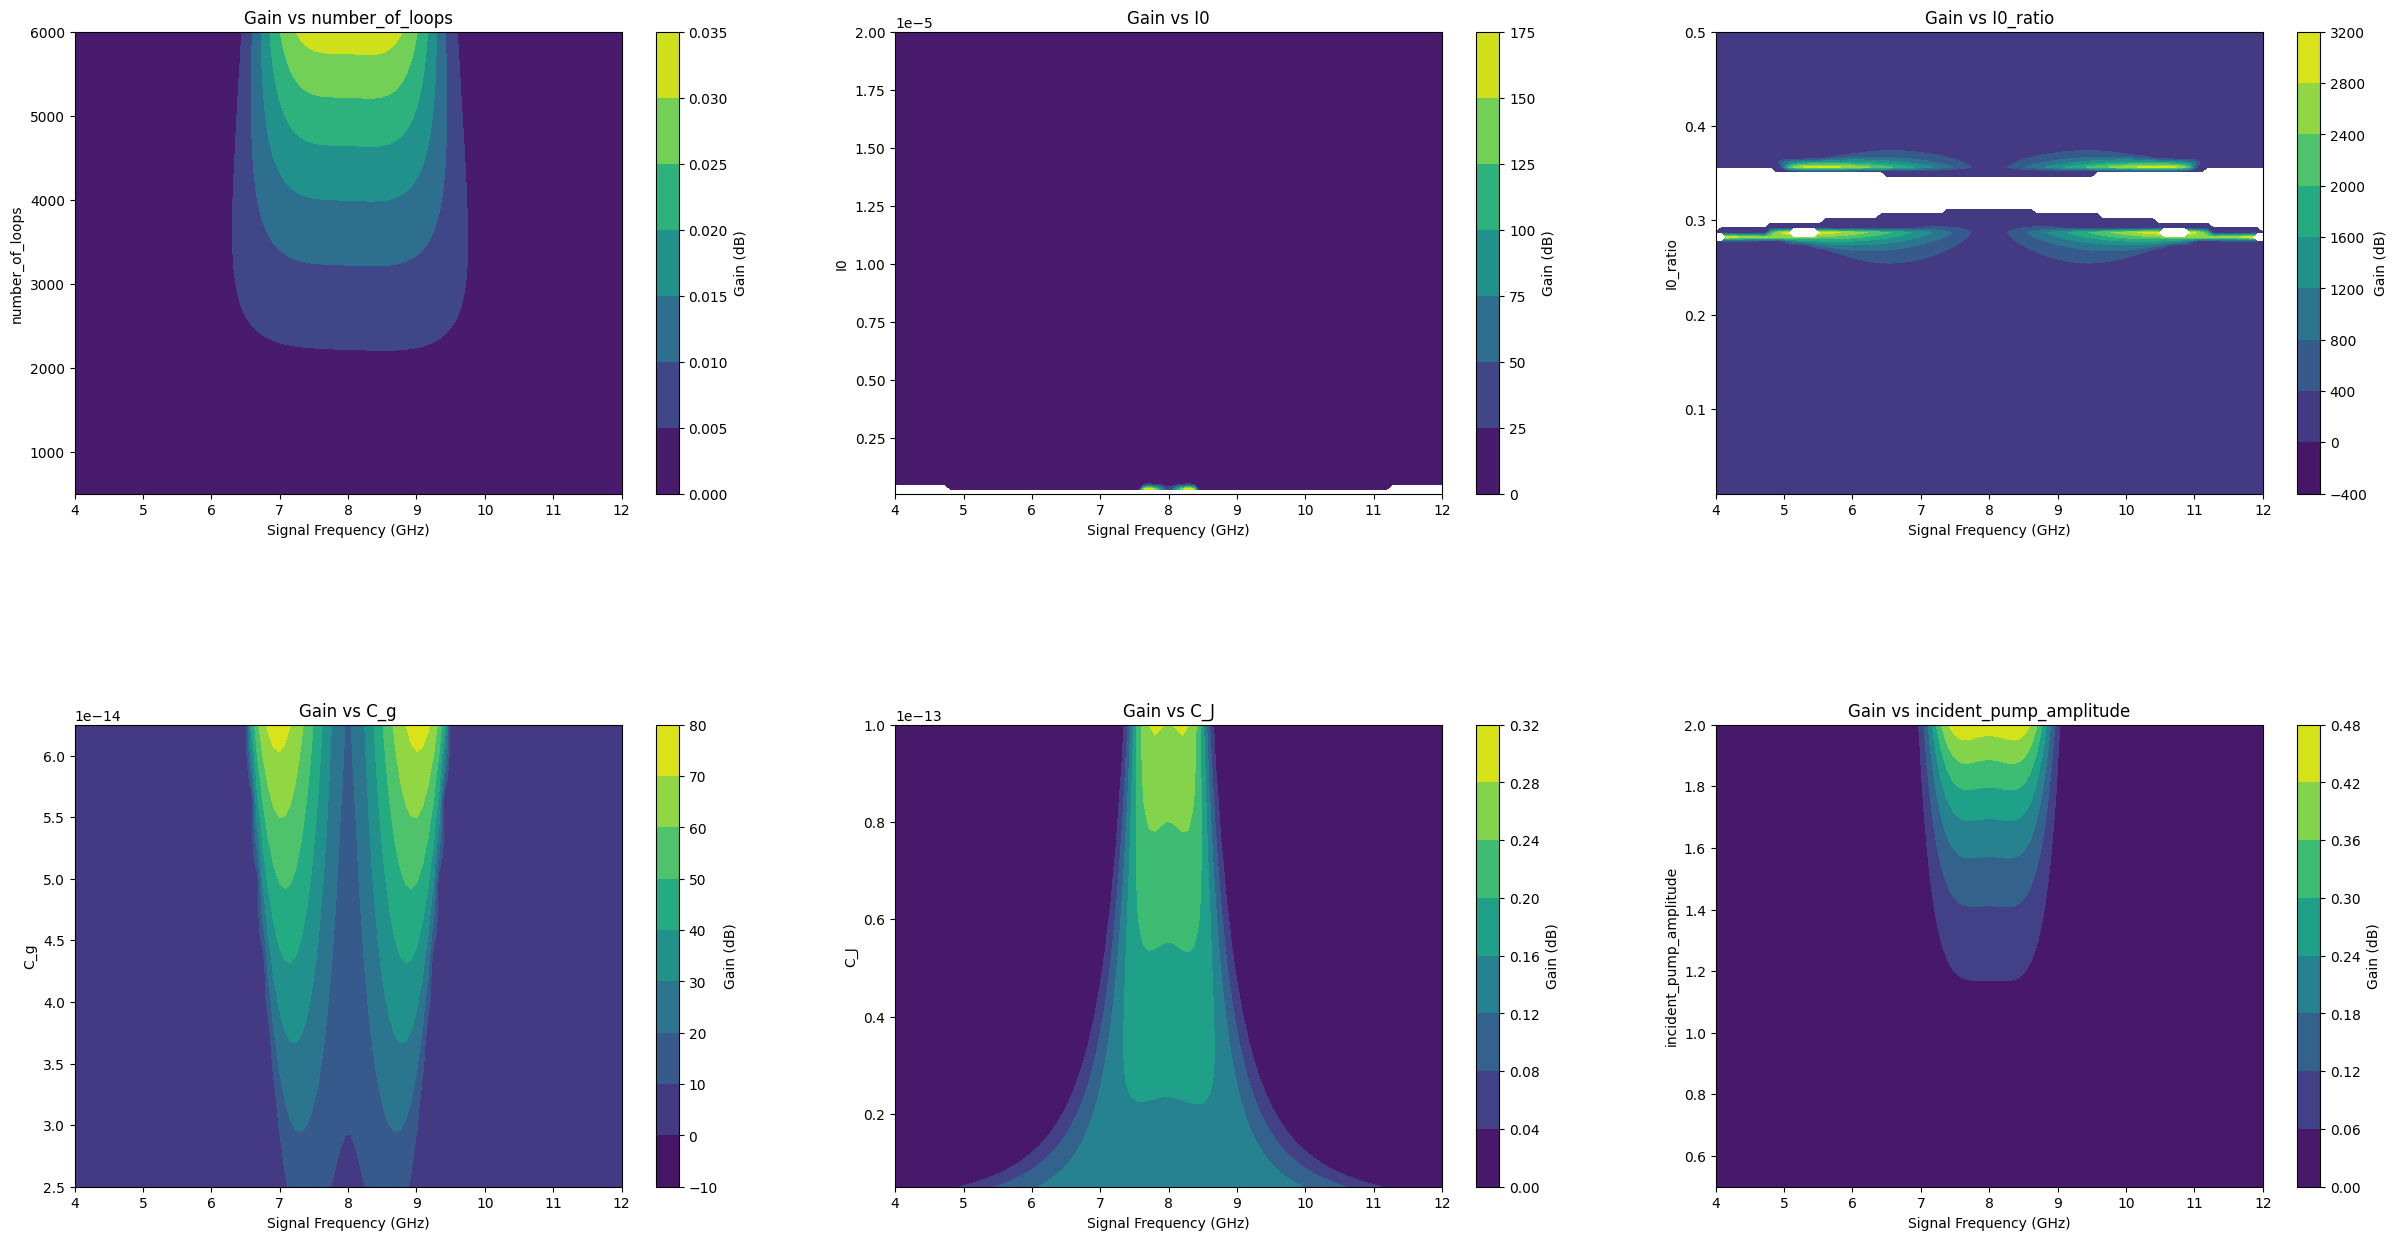

In [7]:
import copy

# Original parameters
original_params = {
    'pump_frequency': 8,
    'incident_pump_amplitude': 1.6,
    'loss_tangent': -1e-6,
    'number_of_loops': 15000,
    'size_of_one_loop': 4e-6,
    'I0': 2.19e-6,
    'I0_ratio': 0.07,
    'C_g': 5e-15,
    'C_J': 50e-15
}

# Create a copy of sim with original parameters
sim_original = copy.deepcopy(dispersion_in_JJ_metamaterial())

for key, value in original_params.items():
    setattr(sim_original, key, value)
sim_original.calculate_loop_parameters()

omega_s_range = np.linspace(4, 12, 1000)
gain_values = sim_original.gain_vs_freq(omega_s_range)

plt.figure(figsize=(8, 6))
plt.plot(omega_s_range, gain_values)
plt.xlabel('Signal Frquency (GHz)')
plt.ylabel(r'Gain (dB)')
plt.title(r'Gain vs $\omega_s$ ($\omega_p$ = 8GHz)')
plt.grid(True)
plt.show()

# Define the parameter ranges to explore
pump_frequencies = [8]  # Keep pump frequency constant
incident_pump_amplitudes = np.linspace(0.5, 2.0, 100)
loss_tangents = np.linspace(-5e-5, -2e-6, 100)
number_of_loops_values = np.linspace(500, 6000, 100)
size_of_one_loop_values = np.linspace(2e-6, 6e-6, 100)
I0_values = np.linspace(2e-5, 1e-7, 100)
I0_ratio_values = np.linspace(0.01, 0.5, 100)
C_J_values = np.linspace(5e-15, 100e-15, 100)
C_g_values = np.linspace(25e-15, 250e-15/4, 100)

# Create a subplot grid
fig, axes = plt.subplots(2, 3, figsize=(30, 15))
fig.subplots_adjust(hspace=0.5)

# Vary different parameters and plot gain maps
for ax, param_values, param_name in zip(axes.flatten(),
                                       [number_of_loops_values, I0_values, I0_ratio_values, C_g_values, C_J_values, incident_pump_amplitudes, loss_tangents],
                                       ['number_of_loops', 'I0', 'I0_ratio', 'C_g', 'C_J', 'incident_pump_amplitude',  'loss_tangent']):
    gains = []
    for param_value in param_values:
        # Create a copy of sim_original for each iteration
        sim_copy = copy.deepcopy(sim_original)

        # Set the parameter value in the simulation copy
        setattr(sim_copy, param_name, param_value)
        sim_copy.calculate_loop_parameters()  # Recalculate loop parameters if needed
        omega_s_range = np.linspace(4, 12, 100)
        gain_values = sim_copy.gain_vs_freq(omega_s_range)
        gains.append(gain_values)

    # Create a contour plot for the gain map
    X, Y = np.meshgrid(omega_s_range, param_values)
    gains = np.array(gains)
    contour = ax.contourf(X, Y, gains, cmap='viridis')
    ax.set_xlabel('Signal Frequency (GHz)')
    ax.set_ylabel(param_name)
    ax.set_title(f'Gain vs {param_name}')

    # Add colorbar legend
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label('Gain (dB)')

# Show the plots
plt.show()

/var/folders/8g/g48bxxwn3139k68mrwrpq2xw0000gn/T/ipykernel_78458/10811950.py:112: RuntimeWarning: invalid value encountered in sqrt
  k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))
/var/folders/8g/g48bxxwn3139k68mrwrpq2xw0000gn/T/ipykernel_78458/10811950.py:129: RuntimeWarning: invalid value encountered in divide
  Phi21 = -1j*eta_i*k_s/(k_i*2)
/var/folders/8g/g48bxxwn3139k68mrwrpq2xw0000gn/T/ipykernel_78458/10811950.py:111: RuntimeWarning: invalid value encountered in sqrt
  k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
/var/folders/8g/g48bxxwn3139k68mrwrpq2xw0000gn/T/ipykernel_78458/10811950.py:128: RuntimeWarning: invalid value encountered in divide
  Phi12 = 1j*eta_s*k_i/(k_s*2)


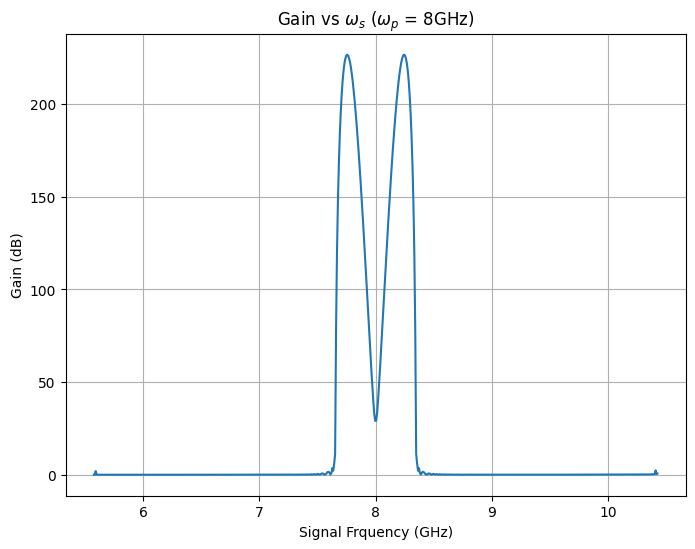

In [11]:
sim = dispersion_in_JJ_metamaterial()
sim.pump_frequency = 8				# in GHz
sim.incident_pump_amplitude = 1.6		

sim.loss_tangent = -1e-6 			# loss tangent
sim.number_of_loops = 15000			# number of loops in the transmission line
sim.size_of_one_loop = 4e-6 	    # size of one SNAIL loop in m
sim.I0 = 0.25e-6					# critical current of large junction
sim.I0_ratio = 0.06				# ratio of critical currents in the SNAIL
sim.C_g = 5e-15					    ## reduced ground capacitance (see notes)##
sim.C_J = 50e-15					# junction capacitance

sim.calculate_loop_parameters()


omega_s_range = np.linspace(4, 12, 1000)
gain_values = sim.gain_vs_freq(omega_s_range)

plt.figure(figsize=(8, 6))
plt.plot(omega_s_range, gain_values)
plt.xlabel('Signal Frquency (GHz)')
plt.ylabel(r'Gain (dB)')
plt.title(r'Gain vs $\omega_s$ ($\omega_p$ = 8GHz)')
plt.grid(True)
plt.show()